In [1]:
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import create_engine
from database import Reactions

engine = create_engine('sqlite:///reactions2.db', echo = False)

Session = sessionmaker(bind=engine)
session = Session()

2022-12-15 20:54:29,760 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2022-12-15 20:54:29,761 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("reactions")
2022-12-15 20:54:29,761 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-12-15 20:54:29,762 INFO sqlalchemy.engine.Engine COMMIT


In [2]:
def getRxnFP(r, fp_type, summed, multipliers):
    if fp_type == "MACCS":
        rxnMatrix = np.zeros((5,167))
    else:
        rxnMatrix = np.zeros((5,2048))
    row = 0
    for k,m in zip(reagent_classes,multipliers):
        sm = getattr(r,k)
        if sm == "NONE":
            fp = np.zeros((1,))
        else:
            if k == "solvent":
                mol = Chem.MolFromSmiles(solv_map[sm])
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
                if "%" in sm:
                    s2 = sm.split("_")[1]
                    mol2 = Chem.MolFromSmiles(solv_map[s2])
                    fp2 = np.zeros((1,))
                    if fp_type == "MACCS":
                        DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp2)
                    else:
                        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp2)

                    fp = np.add(fp,fp2)
            else:
                mol = Chem.MolFromSmiles(sm)
                fp = np.zeros((1,))
                if fp_type == "MACCS":
                    DataStructs.ConvertToNumpyArray(MACCSkeys.GenMACCSKeys(mol), fp)
                else:
                    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, 4), fp)
        fp = fp*m
        rxnMatrix[row,:] = fp
        row = row + 1
    if summed:
        return np.sum(rxnMatrix, axis=0)
    else:
        return rxnMatrix

In [3]:
r = session.query(Reactions).all()


/var/folders/8k/w__0g4xs7rj0xv7hk3dqm71w0000gn/T/ipykernel_10478/3822804417.py:1: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  r = session.query(Reactions).all()


In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem, MACCSkeys
import pandas as pd

reagent_classes = ["electrophile", "nucleophile", "catalyst_smiles", "base_smiles", "solvent"]
solv_map = {"NMP":'O=C1N(C)CCC1', "DMSO":'O=S(C)C',"DMF":'O=CN(C)C', \
            "25%H2O_NMP":'[H]O[H].O=C1N(C)CCC1', "25%H2O_DMSO":'O=S(C)C.[H]O[H]', "25%H2O_DMF":'O=CN(C)C.[H]O[H]', \
            "25%tAmOH_DMSO":"CCC(C)(O)C.O=S(C)C","10%tAmOH_NMP":"CCC(C)(O)C.O=C1N(C)CCC1"}

class_reagents = {k:[] for k in reagent_classes}
multipliers = [1, 1, 1, 1, 1]
yields = []
index_split_by_class = {k:[] for k in reagent_classes}
rxnfps = []
yield_group = []
for k in r:
    if "Suzuki" not in k.reaction_name:
        continue
    print(k.reaction_name)
    if k.output_value > 100:
        continue
    for j in reagent_classes:
        if j=="solvent":
            mol=Chem.MolFromSmiles(solv_map[getattr(k,j)])
            sm = solv_map[getattr(k,j)]
        else:
            mol = Chem.MolFromSmiles(getattr(k,j))
            sm = getattr(k,j)
        if sm not in class_reagents[j]:
            class_reagents[j].append(sm)

        index_split_by_class[j].append(class_reagents[j].index(sm))
    n = k.group
    if k.output_value == 0:
        yield_group.append(0)
    elif k.output_value < 33:
        yield_group.append(1)
    elif k.output_value < 66:
        yield_group.append(2)
    else:
        yield_group.append(3)

    yields.append(float(k.output_value))
    fp = getRxnFP(k, "MFP4", True, multipliers)
    rxnfps.append(fp)

Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boronic acids
Suzuki w/ boroni

In [11]:
import umap

X_UMAP_RFP = umap.UMAP(n_components=2, n_jobs=-1, random_state=1).fit_transform(rxnfps)
X_UMAP_RFP_SEMI = umap.UMAP().fit_transform(rxnfps, y=yields)

In [12]:
print(X_UMAP_RFP_SEMI)

[[ 7.322484   -4.4674883 ]
 [ 7.278075   -4.505016  ]
 [ 7.080637   -7.030198  ]
 ...
 [ 0.9461161  -2.2469747 ]
 [ 2.065575   -1.5749277 ]
 [-0.83773595 -3.0709066 ]]


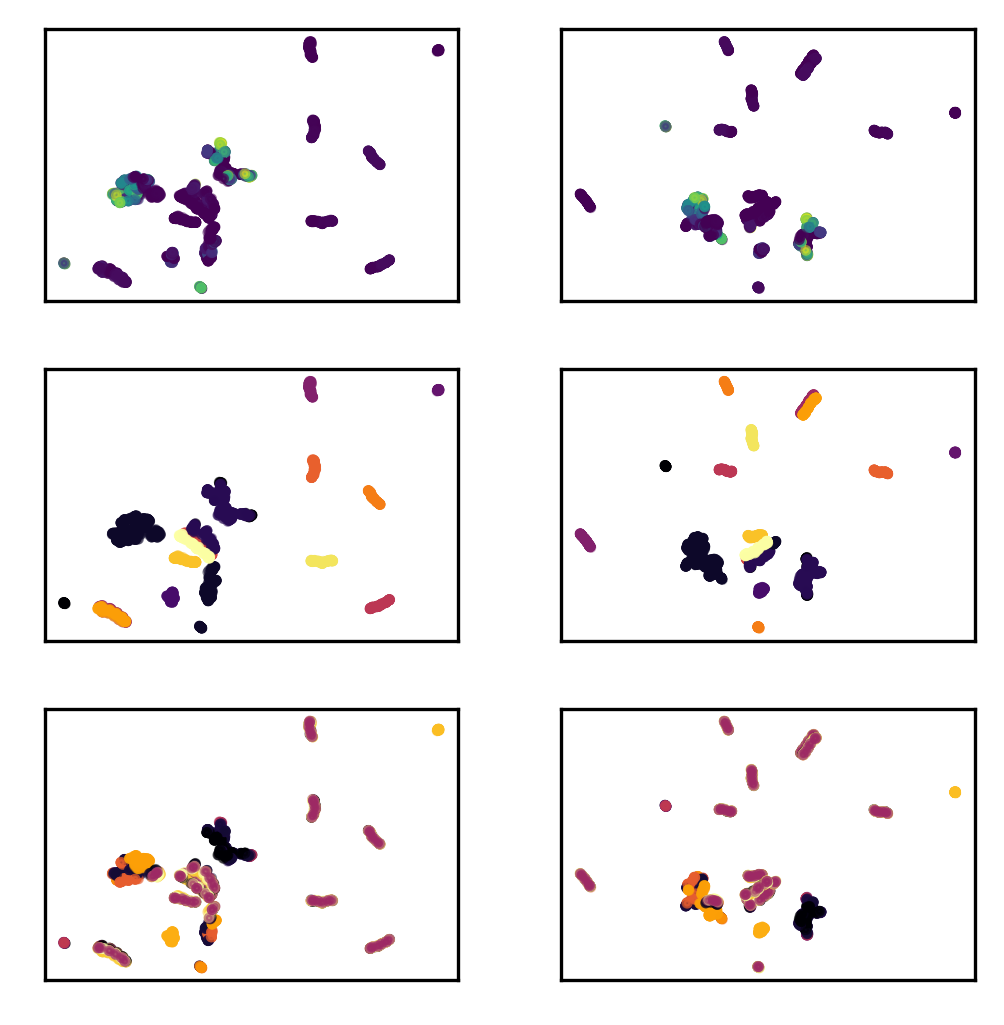

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,2, figsize=(4,4.2), dpi=300)
ax[0][0].scatter(X_UMAP_RFP[:,0], X_UMAP_RFP[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

ax[0][1].scatter(X_UMAP_RFP_SEMI[:,0], X_UMAP_RFP_SEMI[:,1], cmap='viridis', c=yields, alpha=.5, marker='.',s=10, vmax=100, vmin = 0)
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(X_UMAP_RFP[:,0], X_UMAP_RFP[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][0].set_xticks([])
ax[1][0].set_yticks([])

ax[1][1].scatter(X_UMAP_RFP_SEMI[:,0], X_UMAP_RFP_SEMI[:,1], cmap='inferno', c=index_split_by_class["electrophile"], alpha=.5, marker='.',s=10)
ax[1][1].set_xticks([])
ax[1][1].set_yticks([])

ax[2][0].scatter(X_UMAP_RFP[:,0], X_UMAP_RFP[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][0].set_xticks([])
ax[2][0].set_yticks([])

ax[2][1].scatter(X_UMAP_RFP_SEMI[:,0], X_UMAP_RFP_SEMI[:,1], cmap='inferno', c=index_split_by_class["nucleophile"], alpha=.5, marker='.',s=10)
ax[2][1].set_xticks([])
ax[2][1].set_yticks([])


plt.subplots_adjust(wspace=.25, hspace=.25)

plt.savefig('si7.png', dpi=300, bbox_inches='tight',pad_inches=0.01)

In [25]:
water = {"high":0, "med":0,"low":0,"zero":0}
non_water = {"high":0, "med":0,"low":0,"zero":0}

for k in r:
    if "Suzuki" not in k.reaction_name:
        continue

    if k.output_value > 100:
        continue
    
    if "H2O" in k.solvent:
        chi = water
    else:
        chi = non_water
    if k.output_value == 0:
        chi["zero"] = chi["zero"] + 1
    elif k.output_value < 33:
        chi["low"] = chi["low"] + 1
    elif k.output_value < 66:
        chi["med"] = chi["med"] + 1
    else:
        chi["high"] = chi["high"] + 1
    # print(k.solvent)
    

In [29]:
print(water)
print(non_water)

{'high': 129, 'med': 151, 'low': 553, 'zero': 194}
{'high': 0, 'med': 8, 'low': 827, 'zero': 707}


In [30]:
data = []
data1 = []
data2 = []
for k in water:
    data1.append(water[k])
    data2.append(non_water[k])
data = [data1, data2]

In [32]:
import scipy
scipy.stats.chi2_contingency(data)

(521.8286202749276,
 8.869287694320437e-113,
 3,
 array([[ 51.56987155,  63.56286493, 551.6776956 , 360.18956793],
        [ 77.43012845,  95.43713507, 828.3223044 , 540.81043207]]))

In [34]:
water["label"] = ["w/ water"]
non_water["label"] = ["w/o water"]

pd.DataFrame([water, non_water])

,high,med,low,zero,label
0,129,151,553,194,[w/ water]
1,0,8,827,707,[w/o water]
